In [ ]:
!pip install emoji
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 5.0 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=825e211703b80348bba6ae4742b5e5a296f0b59e412b9cb3c5ac523f94443a0b
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.6 MB/s 
     |████████████████████████████████| 596 kB 14.9 MB/s 
     |████████████████████████████████| 86 kB 3.0 MB/s 
     |████████████████████████████████| 6.6 MB 36.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import re, string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
# from nltk.corpus import stopwords


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


from collections import Counter
from gensim.models import Word2Vec


import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import classification_report, confusion_matrix


import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

import time


sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

In [ ]:

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Importing the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MLProject/cyberbullying_tweets.csv")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MLProject/preProcessed.csv") 

In [ ]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [ ]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'label'})

In [ ]:
df.duplicated().sum()

36

In [ ]:
df = df[~df.duplicated()]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    47656 non-null  object
 1   label   47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [ ]:
df.label.value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: label, dtype: int64

In [ ]:

def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text


def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2


def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)


def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)


def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])


def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])


def deep_clean(text):
    text = re.sub(emoji.get_emoji_regexp(), r"", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [ ]:
texts_new = []
for t in df.text:
    texts_new.append(deep_clean(t))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'


In [ ]:
df['text_clean'] = texts_new

In [ ]:
df.head()

,text,label,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock today sunris studi...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...


In [ ]:
df.shape

(47656, 3)

In [ ]:
df["text_clean"].duplicated().sum()

3058

In [ ]:
df.drop_duplicates("text_clean", inplace=True)

In [ ]:
df.shape

(44598, 3)

In [ ]:
df.label.value_counts()

religion               7946
age                    7884
ethnicity              7744
not_cyberbullying      7637
gender                 7607
other_cyberbullying    5780
Name: label, dtype: int64

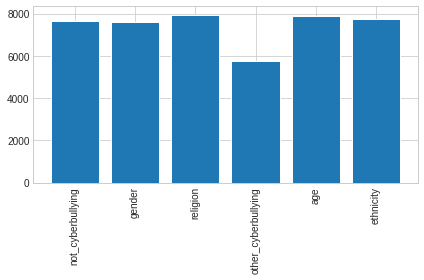

In [ ]:

targets = Counter(df['label'])
plt.bar(targets.keys(), targets.values())
plt.xticks(rotation=90)
plt.show()

In [ ]:
df = df[df["label"]!="other_cyberbullying"]

In [ ]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [ ]:
df['text_len'] = text_len

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


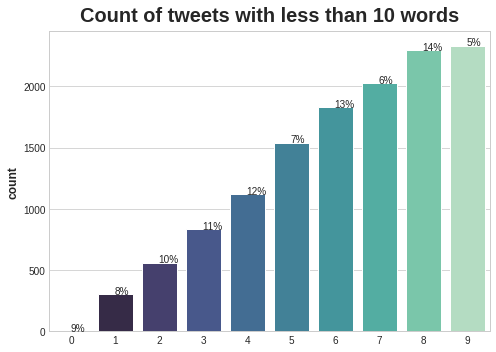

In [ ]:
#Bar Chart
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)

for p, label in zip(ax.patches, df["text_len"].value_counts().index):
    ax.annotate(f'{label}%', (p.get_x()+0.375, p.get_height()+0.15))

plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
df = df[df['text_len'] > 3]

In [ ]:
df.sort_values(by=['text_len'], ascending=False)

,text,label,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white tri live like nigger pahahahaha co...,187
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb ass nigger bitch ltthi whore s...,162
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilti kill feel guilti enjoy torment sin...,137
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,research push import top antibulli program us ...,137
47037,@Purely_Ambition: Sooo mad. RT @TracePeterson ...,ethnicity,sooo mad rt fuck obama dumb nigger go switzerl...,125
...,...,...,...,...
10274,@holliebakerlutz What does that 23% figure rep...,gender,23 figur repres deriv,4
5229,are bully sticks for dogs safe,not_cyberbullying,bulli stick dog safe,4
10314,RT @Mr_LayedBak: I'm not sexist... but women r...,gender,rt sexist women ref,4
5237,*hands you a bag of trail mix*,not_cyberbullying,hand bag trail mix,4


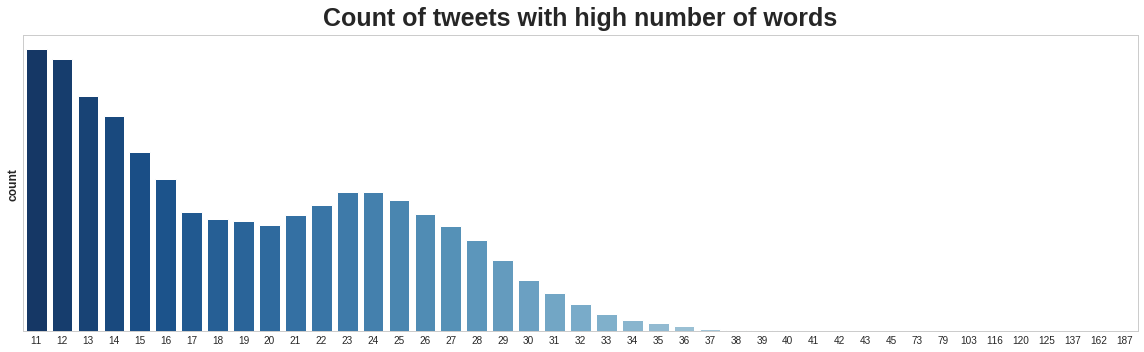

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
df = df[df['text_len'] < 100]

In [ ]:
max_len = np.max(df['text_len'])
max_len 

79

In [ ]:
df.sort_values(by=["text_len"], ascending=False)

,text,label,text_clean,text_len
4846,@andrea_gcav: @viviaanajim recuerdas como noso...,not_cyberbullying,recuerda como nosotra tambin eramo victima del...,79
44294,@JasmineLovvee If He Dont Want You Well Fuck H...,ethnicity,dont want well fuck aint worth tear never swea...,73
45930,"Get off ur ego trip, take off ur rose colored ...",ethnicity,get ur ego trip take ur rose color glass amp g...,45
21241,And yet God was able to meet their needs using...,religion,yet god abl meet need use radic everyday gener...,43
41749,@seijohgorl hoy mami keito AAAA okay so um ika...,ethnicity,hoy mami keito aaaa okay um ikaw talaga one fi...,43
...,...,...,...,...
44750,What the fuck you dumb nigger I hate you now,ethnicity,fuck dumb nigger hate,4
1673,@UMTony lmao! I really wanted to take it down!,not_cyberbullying,lmao realli want take,4
35335,He's a grade school bully. He's a coward!,age,grade school bulli coward,4
3920,Need to let my anger out dude.,not_cyberbullying,need let anger dude,4


In [ ]:
df['label'] = df['label'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

In [ ]:
df.to_csv('/content/drive/MyDrive/MLProject/preProcessed.csv')

In [ ]:
X = df['text_clean']
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5638],
       [   2, 5549],
       [   3, 5264],
       [   4, 4587]])

In [ ]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'label']);

In [ ]:
X_train = train_os['text_clean'].values
y_train = train_os['label'].values

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5683],
       [   2, 5683],
       [   3, 5683],
       [   4, 5683]])

In [ ]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [ ]:
EMBEDDING_DIM = 200

In [ ]:
word2vec_model = Word2Vec(Word2vec_train_data, size=EMBEDDING_DIM)

In [ ]:
def Tokenize(column, seq_len):
    
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

   
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [ ]:
# %%timeit
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

In [ ]:
df["text_clean"].iloc[10]

'love best respons hotcak manag film noncommitt meh adolesc mkr'

In [ ]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

In [ ]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 33009


In [ ]:

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (33009, 200)


In [ ]:


X = tokenized_column
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [ ]:


(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T



array([[   0, 5683],
       [   1, 5638],
       [   2, 5549],
       [   3, 5264],
       [   4, 4587]])

In [ ]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [ ]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5683],
       [   2, 5683],
       [   3, 5683],
       [   4, 5683]])

In [ ]:


train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

BATCH_SIZE = 32

In [ ]:


train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)



In [ ]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

LR = 3e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not
EPOCHS = 5 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

In [ ]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(33009, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:


criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)



In [ ]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 91.576087).  Saving model ...
	Train_loss : 0.6810 Val_loss : 0.2492
	Train_acc : 73.728% Val_acc : 91.576%
Epoch 2:Validation accuracy increased (91.576087 --> 92.866848).  Saving model ...
	Train_loss : 0.1819 Val_loss : 0.2013
	Train_acc : 94.134% Val_acc : 92.867%
Epoch 3:Validation accuracy increased (92.866848 --> 93.512228).  Saving model ...
	Train_loss : 0.1121 Val_loss : 0.1980
	Train_acc : 96.361% Val_acc : 93.512%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0744 Val_loss : 0.2239
	Train_acc : 97.608% Val_acc : 93.003%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0505 Val_loss : 0.2770
	Train_acc : 98.499% Val_acc : 91.236%


In [ ]:


model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())




In [ ]:
matches = np.count_nonzero(np.array(y_pred_list) == np.array(y_test_list))
mismatches = np.array(y_test_list).size - matches
print(f'matches: {matches}')
print(f'mismatches: {mismatches}')
print(f'test accuracy: {matches /np.array(y_test_list).size * 100}')

matches: 6775
mismatches: 617
test accuracy: 91.65313852813853


In [ ]:

def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

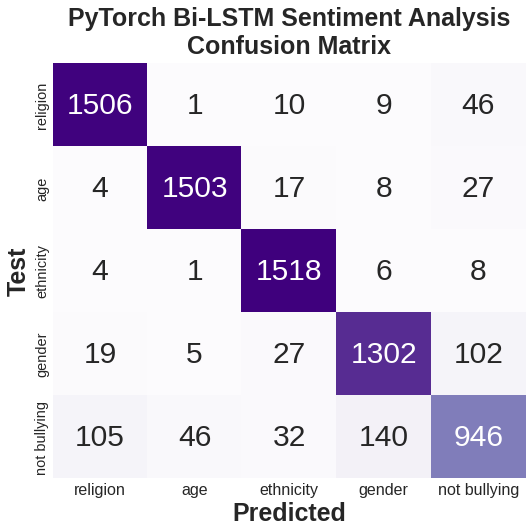

In [ ]:
conf_matrix(y_test_list,y_pred_list,'PyTorch Bi-LSTM Sentiment Analysis\nConfusion Matrix', sentiments)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/MLProject/lstm.pth')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        
            max_length=MAX_LEN,             
            pad_to_max_length=True,         
            return_attention_mask=True      
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]


max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

NameError: ignored

In [ ]:
df['text_clean'].head()

0                   word katandandr food crapilici mkr
1    aussietv white mkr theblock today sunris studi...
2                       classi whore red velvet cupcak
3    meh p thank head concern anoth angri dude twitter
4    isi account pretend kurdish account like islam...
Name: text_clean, dtype: object

In [ ]:
MAX_LEN = 128

In [ ]:
X = df['text_clean'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T


array([[   0, 5683],
       [   1, 5638],
       [   2, 5549],
       [   3, 5264],
       [   4, 4587]])

In [ ]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [ ]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [ ]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5683],
       [   2, 5683],
       [   3, 5683],
       [   4, 5683]])

In [ ]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

In [ ]:
batch_size = 32

In [ ]:

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# %%time
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        n_input = 768
        n_hidden = 50
        n_output = 5
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.classifier = nn.Sequential(
            nn.Linear(n_input,  n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
temp = 'hello this is bullshit'
# encoded = tokenizer.encode(temp, add_special_tokens=True)
MAX_LEN = 128
id, mask = bert_tokenizer(temp)
print(id.shape, mask.shape)
model = Bert_Classifier(freeze_bert=False)

model.eval()
out = model(id, mask)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


torch.Size([22, 128]) torch.Size([22, 128])


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/MLProject/BERT/bert_final.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
def initialize_model(epochs=4):
    bert_classifier = Bert_Classifier(freeze_bert=False)
    
    bert_classifier.to(device)

    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    
                      eps=1e-8    
                      )
    

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

In [ ]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

In [ ]:
for i in train_dataloader:
  print(i[0].shape)
  print(i[1].shape)
  print(i[2].shape)
  break

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


In [ ]:
from torch.nn.modules.module import _addindent
import torch
import numpy as np
def torch_summarize(model, show_weights=True, show_parameters=True):
    """Summarizes torch model by showing trainable parameters and weights."""
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
            torch.nn.modules.container.Container,
            torch.nn.modules.container.Sequential
        ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)

        params = sum([np.prod(p.size()) for p in module.parameters()])
        weights = tuple([tuple(p.size()) for p in module.parameters()])

        tmpstr += '  (' + key + '): ' + modstr 
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'   

    tmpstr = tmpstr + ')'
    return tmpstr

In [ ]:
# from torchsummary import summary
# summary(bert_classifier, [(1,128), (1, 128)])
print(torch_summarize(bert_classifier))


Bert_Classifier (
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [ ]:
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        

        # Training the model
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()

            logits = model(b_input_ids, b_attn_mask)

            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            
            scheduler.step()

            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        #Evaluating the model
        model.eval()
        
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            preds = torch.argmax(logits, dim=1).flatten()

            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

In [ ]:
# %%time
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.589873   |   60.79  
   200    |   0.280485   |   65.47  
   300    |   0.229226   |   65.60  
   400    |   0.245918   |   66.15  
   500    |   0.215474   |   65.92  
   600    |   0.220536   |   66.49  
   700    |   0.193350   |   65.85  
   800    |   0.199971   |   66.05  
   887    |   0.185860   |   57.43  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.263787    |  0.191462  |       93.76       |  602.35  
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.139792   |   66.72  
   2

In [ ]:
def bert_predict(model, test_dataloader):
    
    preds_list = []
    
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        preds_list.extend(pred)

    return preds_list

In [ ]:
torch.save(bert_classifier.state_dict(), '/content/drive/MyDrive/MLProject/BERT/bert_hidden_40.pth')

In [ ]:
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [ ]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

In [ ]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [ ]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)

In [ ]:
model = Bert_Classifier(freeze_bert=False)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/MLProject/BERT/bert_final.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# bert_classifier.save_model('/content/drive/MyDrive/MLProject/BERT', local_files_only=True)

In [ ]:

def DEMO_BERT_CLASSIFIER(model, text):

  MAX_LEN = 128
  id, mask = bert_tokenizer([text])
  out = model(id, mask)
  preds = torch.argmax(out, dim=1).cpu().numpy()
  print(preds)
  preds_label = {0: 'religion',1:'age',2:'ethnicity',3:'gender',4:'not_cyberbullying'}
  print([preds_label[i] for i in preds])

In [ ]:
MAX_LEN=128

In [ ]:
DEMO_BERT_CLASSIFIER(model, 'jews should not be allowd to live')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[0]
['religion']


In [ ]:
demo(model, 'Muslims are terroist')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[0]
['religion']


In [ ]:
demo(model, 'he is gay and stupid')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[3]
['gender']


In [ ]:
df[df['label'] == 1].head()

,Unnamed: 0,text,label,text_clean,text_len
21575,31739,Here at home. Neighbors pick on my family and ...,1,home neighbor pick famili mind son autist feel...,27
21576,31740,Being bullied at school: High-achieving boys u...,1,bulli school highachiev boy use strategi maint...,16
21577,31741,There was a girl in my class in 6th grade who ...,1,girl class 6th grade littl autist parent thoug...,24
21578,31742,He’s probably a white gay kid from some suburb...,1,he probabl white gay kid suburb dont want shoo...,12
21579,31743,You are pushed ti resorting. Treating thr bull...,1,push ti resort treat thr bulli percent pressur...,17


In [ ]:
# temp = 'hello this is bullshit'
# encoded = tokenizer.encode(temp, add_special_tokens=True)
MAX_LEN = 128
id, mask = bert_tokenizer([temp])
out = model(id, mask)
torch.argmax(out, dim=1).cpu().numpy()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


array([4])

In [ ]:
# bert_classifier.load_state_dict(torch.load('/content/drive/MyDrive/MLProject/BERT/bert_final.pth'))

In [ ]:
arr = []
arr.extend( torch.argmax(out, dim=1).cpu().numpy())
arr


[4]